In [42]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np,cupy as cp, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
#import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)
piyg = cm.get_cmap('PiYG', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

import glob, root_pandas
from scipy.optimize import curve_fit

import misc_util

image_dir = "/home/sebouh/dihadron-analysis-note/images/"

def read_n(pattern, n):
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        del a
        print(n)
        return b

In [34]:
#inb = read_n('/home/sebouh/tuples_hadd/inbend_mixed_small.root',1e6)
outb = read_n('/home/sebouh/tuples_hadd/outbend_mixed_test.root*.root',1e9)

1000000000.0


In [35]:
inb = read_n('/home/sebouh/tuples_hadd/inbend_mixed_test.root*.root',1e9)

1000000000.0


In [36]:
inb = read_n(glob.glob('../in/data_test_inb_mix*.root'),1e6)
outb = read_n(glob.glob('../in/data_test_inb_mix*.root'),1e6)

1000000.0
1000000.0


In [37]:
mixed_small = read_n(glob.glob('/home/sebouh/tuples_hadd/*_mixed_small.root'),1e6)

1000000.0


In [38]:
inb_same=read_n(glob.glob('/home/sebouh/tuples_hadd/inbend_dihadrons*.root'),1e6)

outb_same = read_n(glob.glob('/home/sebouh/tuples_hadd/outbend_dihadrons*.root'),1e6)

1000000.0
1000000.0


In [27]:

outb_fast = read_n('/home/sebouh/tuples_hadd/outbend_mixed_fast.root*.root',1e9)
inb_fast = read_n('/home/sebouh/tuples_hadd/inbend_mixed_fast.root*.root',1e9)

1000000000.0
1000000000.0


chi2 is  440.63312827361824 ; ndof is  398 0.06894383544297417


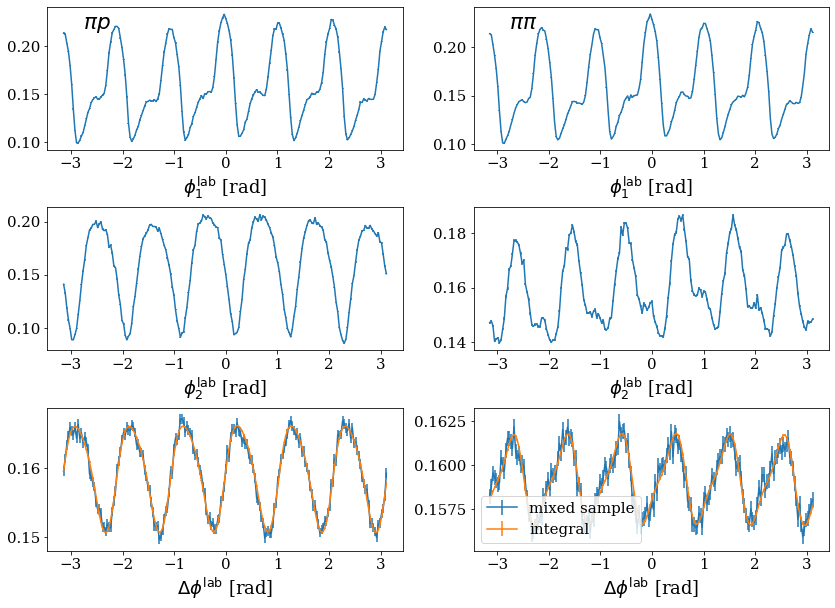

In [54]:
bins =200

concat = pd.concat((inb,outb))
for df,tag in zip([concat],['concat']):
    fig,axs = plt.subplots(3,2,figsize=(14,10))
    fig.subplots_adjust(hspace=0.4)
    chi2,ndof = 0,0
    for j,q in enumerate('h2_pid==2212 abs(h2_pid)==211'.split()):
        dfq = df.query(q)
        
        
        y1,x = np.histogram(dfq.h1_ph, bins=bins, range=(-np.pi,np.pi))
        y2,x = np.histogram(dfq.h2_ph, bins=bins, range=(-np.pi,np.pi))
        
        #shift so that there is a bin centered at 0.  
        shift = -np.pi/bins
        dph = dfq.h1_ph-dfq.h2_ph
        dph +=-2*np.pi*(dph>np.pi+shift)+2*np.pi*(dph<-np.pi+shift)
        y3,x = np.histogram(dph, bins=bins, range=(-np.pi+shift,np.pi+shift))


        x = (pd.Series(x[1:])+x[:-1])/2
        dx = x[1]-x[0]

        denom = sum(y1)*dx
        dy1 = np.sqrt(y1)/denom
        y1 = y1/denom

        denom = sum(y2)*dx
        dy2 = np.sqrt(y2)/denom
        y2 = y2/denom

        denom = sum(y3)*dx
        dy3 = np.sqrt(y3)/denom
        y3 = y3/denom
        
        y4 = []
        dy4 = []
        for k in range(bins):
            sum1 = 0
            sum2 = 0
            for i in range(bins):
                sum1 += y1[(i+k)%bins]*y2[i]*dx
                sum2 += ((dy1[(i+k)%bins]*y2[i] + y1[(i+k)%bins]*dy2[i])*dx)**2
            y4.append(sum1)
            dy4.append(np.sqrt(sum2))
        y4 = pd.Series(y4[bins//2:]+y4[:bins//2])
        dy4 = pd.Series(dy4[bins//2:]+dy4[:bins//2])
        axs[0][j].errorbar(x, y1,dy1)
        axs[1][j].errorbar(x, y2,dy2)
        axs[2][j].errorbar(x, y3,dy3,label='mixed sample')
        axs[2][j].errorbar(x, y4,dy4,label='integral')
        
        
        xlabels = '$\\phi^{\\mathrm{lab}}_1$ [rad];$\\phi^{\\mathrm{lab}}_2$ [rad];$\\Delta\\phi^{\\mathrm{lab}}$ [rad]'.split(';')
        for i in range(3):
            axs[i][j].set_xlabel(xlabels[i],fontsize='large')
        
        chi2 += sum((y4-y3)**2/(dy4**2+dy3**2))
        ndof+=bins-1
        
    from scipy.stats import chi2 as chi2lib
    print("chi2 is ", chi2, "; ndof is ", ndof, chi2lib.sf(chi2, ndof))
    axs[2][-1].legend()
    axs[0][0].text(0.1,0.85, "$\\pi p$",transform=axs[0][0].transAxes,fontsize='x-large')
    axs[0][1].text(0.1,0.85, "$\\pi\\pi$",transform=axs[0][1].transAxes,fontsize='x-large')
    plt.savefig(image_dir+'mix_test_%s.pdf'%tag)
    

chi2 is  440.63312827361824 ; ndof is  398 1.1071184127477844 0.06894383544297417


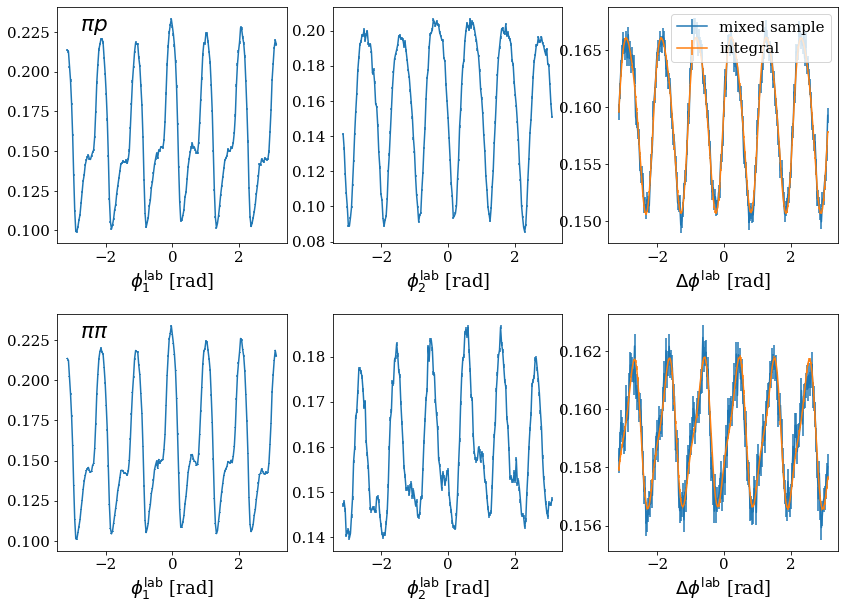

In [61]:
bins =200

#concat = pd.concat((inb,outb))
for df,tag in zip([concat],['concat']):
    fig,axs = plt.subplots(2,3,figsize=(14,10))
    fig.subplots_adjust(hspace=0.3)
    chi2,ndof = 0,0
    for j,q in enumerate('h2_pid==2212 abs(h2_pid)==211'.split()):
        dfq = df.query(q)
        
        
        y1,x = np.histogram(dfq.h1_ph, bins=bins, range=(-np.pi,np.pi))
        y2,x = np.histogram(dfq.h2_ph, bins=bins, range=(-np.pi,np.pi))
        
        #shift so that there is a bin centered at 0.  
        shift = -np.pi/bins
        dph = dfq.h1_ph-dfq.h2_ph
        dph +=-2*np.pi*(dph>np.pi+shift)+2*np.pi*(dph<-np.pi+shift)
        y3,x = np.histogram(dph, bins=bins, range=(-np.pi+shift,np.pi+shift))


        x = (pd.Series(x[1:])+x[:-1])/2
        dx = x[1]-x[0]

        denom = sum(y1)*dx
        dy1 = np.sqrt(y1)/denom
        y1 = y1/denom

        denom = sum(y2)*dx
        dy2 = np.sqrt(y2)/denom
        y2 = y2/denom

        denom = sum(y3)*dx
        dy3 = np.sqrt(y3)/denom
        y3 = y3/denom
        
        y4 = []
        dy4 = []
        for k in range(bins):
            sum1 = 0
            sum2 = 0
            for i in range(bins):
                sum1 += y1[(i+k)%bins]*y2[i]*dx
                sum2 += ((dy1[(i+k)%bins]*y2[i] + y1[(i+k)%bins]*dy2[i])*dx)**2
            y4.append(sum1)
            dy4.append(np.sqrt(sum2))
        y4 = pd.Series(y4[bins//2:]+y4[:bins//2])
        dy4 = pd.Series(dy4[bins//2:]+dy4[:bins//2])
        axs[j][0].errorbar(x, y1,dy1)
        axs[j][1].errorbar(x, y2,dy2)
        axs[j][2].errorbar(x, y3,dy3,label='mixed sample')
        axs[j][2].errorbar(x, y4,dy4,label='integral')
        
        
        xlabels = '$\\phi^{\\mathrm{lab}}_1$ [rad];$\\phi^{\\mathrm{lab}}_2$ [rad];$\\Delta\\phi^{\\mathrm{lab}}$ [rad]'.split(';')
        for i in range(3):
            axs[j][i].set_xlabel(xlabels[i],fontsize='large')
        
        chi2 += sum((y4-y3)**2/(dy4**2+dy3**2))
        ndof+=bins-1
        
    from scipy.stats import chi2 as chi2lib
    print("chi2 is ", chi2, "; ndof is ", ndof,chi2/ndof, chi2lib.sf(chi2, ndof))
    axs[0][-1].legend(loc='upper right')
    axs[0][0].text(0.1,0.9, "$\\pi p$",transform=axs[0][0].transAxes,fontsize='x-large')
    axs[1][0].text(0.1,0.9, "$\\pi\\pi$",transform=axs[1][0].transAxes,fontsize='x-large')
    plt.savefig(image_dir+'mix_test_%s.pdf'%tag)
    

In [7]:

concat = pd.concat((inb_same,outb_same))

In [8]:

concat_mixed = pd.concat((inb,outb))

50 50 50
50 50 50
chi2 is  96392.68239414615 ; ndof is  98 983.5987999402669 0.0


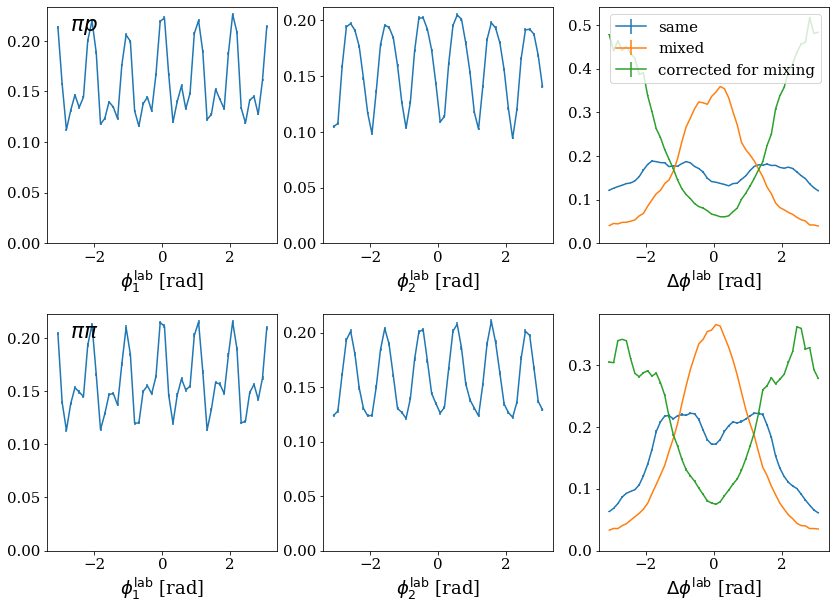

In [41]:
bins =50

for df,tag in zip([concat],['concat_same']):
    fig,axs = plt.subplots(2,3,figsize=(14,10))
    fig.subplots_adjust(hspace=0.3)
    chi2,ndof = 0,0
    for j,qq in enumerate('h2_pid==2212 abs(h2_pid)==211'.split()):
        q = qq + " and h2_z<0.5 and h2_z>0.2"
        dfq = df.query(q)
        
        
        y1,x = np.histogram(dfq.h1_ph, bins=bins, range=(-np.pi,np.pi))
        y2,x = np.histogram(dfq.h2_ph, bins=bins, range=(-np.pi,np.pi))
        
        #shift so that there is a bin centered at 0.  
        shift = 0
        dph = dfq.h1_ph-dfq.h2_ph
        dph +=-2*np.pi*(dph>np.pi+shift)+2*np.pi*(dph<-np.pi+shift)
        y3,x = np.histogram(dph, bins=bins, range=(-np.pi+shift,np.pi+shift))


        x = (pd.Series(x[1:])+x[:-1])/2
        dx = x[1]-x[0]

        denom = sum(y1)*dx
        dy1 = np.sqrt(y1)/denom
        y1 = y1/denom
        
        denom = sum(y2)*dx
        dy2 = np.sqrt(y2)/denom
        y2 = y2/denom

        denom = sum(y3)*dx
        dy3 = np.sqrt(y3)/denom
        y3 = y3/denom
        
        y4 = []
        dy4 = []
        
        y5,_ = np.histogram(mixed_small.query(q).diff_phi_lab, bins=bins, range=(-np.pi+shift,np.pi+shift))
        y5 = y5/(np.sum(y5)*dx)
        for k in range(bins):
            sum1 = 0
            sum2 = 0
            for i in range(bins):
                sum1 += y1[(i+k)%bins]*y2[i]*dx
                sum2 += ((dy1[(i+k)%bins]*y2[i] + y1[(i+k)%bins]*dy2[i])*dx)**2
            y4.append(sum1)
            dy4.append(np.sqrt(sum2))
        y4 = pd.Series(y4[bins//2:]+y4[:bins//2])
        dy4 = pd.Series(dy4[bins//2:]+dy4[:bins//2])
        
        
        print(len(y1),len(x),len(dy1))
        axs[j][0].errorbar(x, y1,dy1)
        axs[j][1].errorbar(x, y2,dy2)
        axs[j][2].errorbar(x, y3,dy3,label='same')
        axs[j][2].errorbar(x, y5,0,label='mixed')
        #axs[j][2].errorbar(x, y4,dy4,label='integral')
        #axs[j][2].errorbar(x, y3/y4/(2*np.pi),dy3,label='??')
        axs[j][2].errorbar(x, y3/y5/(2*np.pi),dy3,label='corrected for mixing')
        
        
        xlabels = '$\\phi^{\\mathrm{lab}}_1$ [rad];$\\phi^{\\mathrm{lab}}_2$ [rad];$\\Delta\\phi^{\\mathrm{lab}}$ [rad]'.split(';')
        for i in range(3):
            axs[j][i].set_xlabel(xlabels[i],fontsize='large')
            axs[j][i].set_ylim(0)
        chi2 += sum((y4-y3)**2/(dy4**2+dy3**2))
        ndof+=bins-1
        
    from scipy.stats import chi2 as chi2lib
    print("chi2 is ", chi2, "; ndof is ", ndof,chi2/ndof, chi2lib.sf(chi2, ndof))
    axs[0][-1].legend(loc='upper right')
    axs[0][0].text(0.1,0.9, "$\\pi p$",transform=axs[0][0].transAxes,fontsize='x-large')
    axs[1][0].text(0.1,0.9, "$\\pi\\pi$",transform=axs[1][0].transAxes,fontsize='x-large')
    plt.savefig(image_dir+'mix_test_%s.pdf'%tag)
    

Index(['nelectrons', 'E', 'mixevt_E', 'helicity', 'mixevt_helicity', 'e_p',
       'mixevt_e_p', 'e_th', 'mixevt_e_th', 'e_ph', 'mixevt_e_ph', 'e_px',
       'mixevt_e_px', 'e_py', 'mixevt_e_py', 'e_pz', 'mixevt_e_pz', 'nu',
       'mixevt_nu', 'Q2', 'mixevt_Q2', 'x', 'mixevt_x', 'y', 'mixevt_y', 'W',
       'mixevt_W', 'ntracks', 'nhtracks', 'h1_chi2pid', 'h2_chi2pid', 'h1_pid',
       'h2_pid', 'h1_p', 'h2_p', 'h1_th', 'h2_th', 'h1_ph', 'h2_ph', 'h1_px',
       'h2_px', 'h1_py', 'h2_py', 'h1_pz', 'h2_pz', 'h1_DC1x', 'h2_DC1x',
       'h1_DC1y', 'h2_DC1y', 'h1_DC2x', 'h2_DC2x', 'h1_DC2y', 'h2_DC2y',
       'h1_DC3x', 'h2_DC3x', 'h1_DC3y', 'h2_DC3y', 'dvz', 'z', 'h1_cm_p',
       'h1_cm_th', 'h1_cm_ph', 'h2_cm_ph', 'h1_cm_eta', 'h1_cm_rap',
       'h2_cm_rap', 'h1_cm_pt', 'h2_cm_pt', 'h1_cm_zeta', 'h2_cm_zeta',
       'h1_eta', 'h2_eta', 'dtime', 'dtime_corr', 'missing_mass', 'h1_z',
       'h2_z', 'q_th', 'mixevt_q_th', 'mixevt_nskipped', 'diff_phi_cm',
       'diff_phi_lab', 'diff_ra

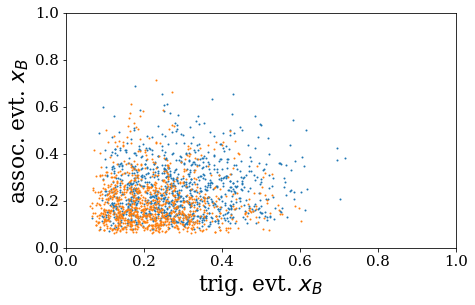

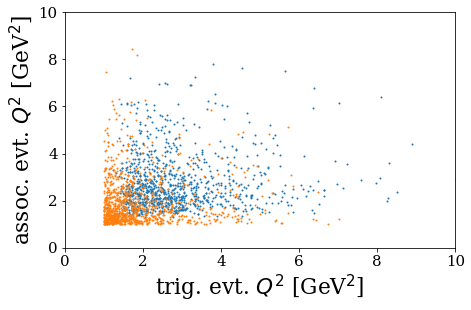

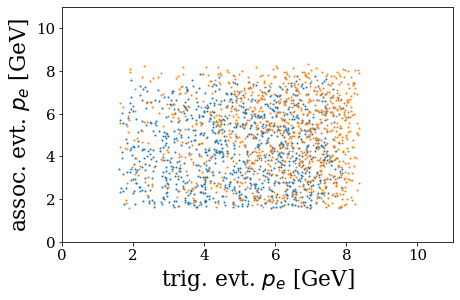

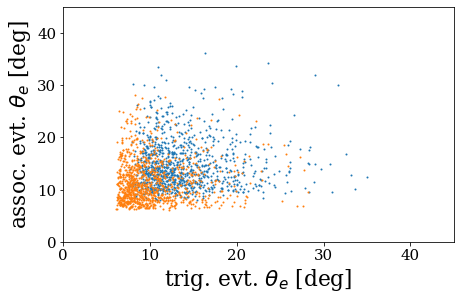

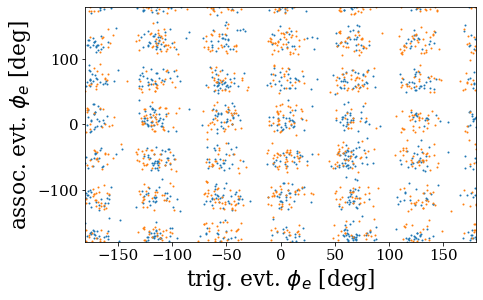

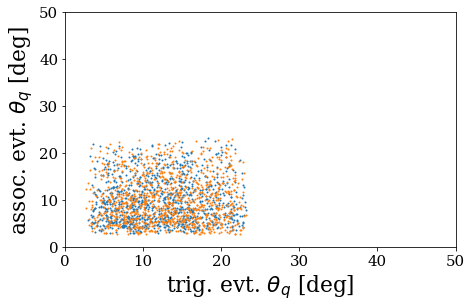

In [4]:
variables = []
variables.append(['x',0,1,'$x_B$ ','x'])
variables.append(['Q2',0,10,'$Q^2$ [GeV$^2$]','Q2'])
variables.append(['e_p',0,11,'$p_e$ [GeV]','e_p'])
variables.append(['e_th*180/3.14159',0,45,'$\\theta_e$ [deg]','e_th'])
variables.append(['e_ph*180/3.14159',-180,180,'$\\phi_e$ [deg]','e_ph'])
variables.append(['q_th*180/3.14159',0,50,'$\\theta_q$ [deg]','q_th'])

print(inb.columns)
n=1000
for var in variables:
    expr, mn,mx, lbl,tag = var
    plt.scatter(inb[::len(inb)//n].eval(expr),inb[::len(inb)//n].eval("mixevt_"+expr),1,color='tab:blue')
    plt.scatter(outb[::len(outb)//n].eval(expr),outb[::len(outb)//n].eval("mixevt_"+expr),1,color='tab:orange')
    plt.gca().set_xlabel('trig. evt. ' + lbl)
    plt.gca().set_ylabel('assoc. evt. ' + lbl)
    plt.ylim(mn,mx)
    plt.xlim(mn,mx)
    plt.savefig("../images/mixevt_diagnostics_" + tag + ".pdf")
    plt.show()
    

In [6]:
print(len(inb_same),len(outb_same))

6828158 21732565


In [7]:
def corr1d(mixed, same,var='labdphi', filename=None,axs = None,label=None,bins=50):
    if(axs is None):
        fig, axs = plt.subplots(1,3, figsize=(14,5))
    if var =='labdphi':
        dph = same.h1_ph-same.h2_ph
        dph +=-2*np.pi*(dph>np.pi)+2*np.pi*(dph<-np.pi)
        ys,x = np.histogram(dph, bins=bins, range=(-np.pi,np.pi))
        dph = mixed.h1_ph-mixed.h2_ph
        dph +=-2*np.pi*(dph>np.pi)+2*np.pi*(dph<-np.pi)
        ym,x = np.histogram(dph, bins=bins, range=(-np.pi,np.pi))
    if var == 'labpairphi':
        expr = 'arctan2(h1_py+h2_py,h1_px+h2_px)'
        ys,x = np.histogram(same.eval(expr), bins=bins, range=(-np.pi,np.pi))
        ym,x = np.histogram(mixed.eval(expr), bins=bins, range=(-np.pi,np.pi))
    x = (pd.Series(x[1:])+x[:-1])/2
    dys = np.sqrt(ys)
    dym = np.sqrt(ym)
    
    
    dx = x[1]-x[0]
    dys=dys/(np.sum(ys)*dx)
    ys=ys/(np.sum(ys)*dx)
    dym=dym/(np.sum(ym)*dx)
    ym=ym/(np.sum(ym)*dx)
    
    print(len(x),len(ym),len(ys))
    yc = ys/ym
    dyc = yc*np.hypot(dys/ys, dym/ym)
    axs[0].errorbar(x,ys,dys, linestyle='', label =label,marker='o',markersize=2)
    axs[1].errorbar(x,ym,dym, linestyle='', label =label,marker='o',markersize=2)
    axs[2].errorbar(x,yc,dyc, linestyle='', label =label,marker='o',markersize=2)
    
    if var =='labdphi':
        axs[0].set_title("$S(\\Delta\\phi_\\mathrm{lab})$")
        axs[1].set_title("$M(\\Delta\\phi_\\mathrm{lab})$")
        axs[2].set_title("$C(\\Delta\\phi_\\mathrm{lab})$")
    if var =='labpairphi':
        axs[0].set_title("$S(\\phi_\\mathrm{lab,pair})$")
        axs[1].set_title("$M(\\phi_\\mathrm{lab,pair})$")
        axs[2].set_title("$C(\\phi_\\mathrm{lab,pair})$")
    
    for ax in axs:
        #ax.set_ylim(0)
        if var =='labdphi':
            ax.set_xlabel('$\\Delta\\phi$ lab [rad]')
        if var =='labpairphi':
            ax.set_xlabel('$\\phi_{\\mathrm{pair}}$ lab [rad]')
    

In [ ]:
q = "h1_cm_pt>0"
fig, axs = plt.subplots(1,3, figsize=(14,5))
corr1d(inb.query("abs(h2_pid) == 211 and "+q),inb_same.query("abs(h2_pid) == 211 and "+q),axs = axs, label='$\\pi p$')
corr1d(inb.query("h2_pid == 2212"),inb_same.query("h2_pid == 2212"),axs = axs, label='$\\pi\\pi$')
axs[0].legend()
for ax in axs:
    ax.set_ylim(0)
plt.savefig('../images/smc_lab_inb.pdf',bbox_inches='tight')
plt.show()
fig, axs = plt.subplots(1,3, figsize=(14,5))
corr1d(outb.query("abs(h2_pid) == 211 and "+q),outb_same.query("abs(h2_pid) == 211 and "+q),axs = axs, label='$\\pi p$')
corr1d(outb.query("h2_pid == 2212 and "+q),outb_same.query("h2_pid == 2212 and "+q),axs = axs, label='$\\pi\\pi$')
axs[0].legend()
for ax in axs:
    ax.set_ylim(0)
plt.savefig('../images/smc_lab_outb.pdf',bbox_inches='tight')
plt.show()

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(14,5))
q = 'h2_z<0.5'
q = 'h2_z>0.1'

corr1d(inb.query("abs(h2_pid) == 211 and "+q),inb_same.query("abs(h2_pid) == 211 and "+q),axs = axs, label='$\\pi p$',var='labpairphi')
corr1d(inb.query("h2_pid == 2212 and "+q),inb_same.query("h2_pid == 2212 and "+q),axs = axs, label='$\\pi\\pi$',var='labpairphi')
axs[0].legend()
for ax in axs:
    ax.set_ylim(0)
plt.savefig('../images/smc_pair_phi_lab_inb.pdf',bbox_inches='tight')
plt.show()
fig, axs = plt.subplots(1,3, figsize=(14,5))
corr1d(outb.query("abs(h2_pid) == 211  and "+q),outb_same.query("abs(h2_pid) == 211 and "+q),axs = axs, label='$\\pi p$',var='labpairphi')
corr1d(outb.query("h2_pid == 2212 and "+q),outb_same.query("h2_pid == 2212  and "+q),axs = axs, label='$\\pi\\pi$',var='labpairphi')
axs[0].legend()
for ax in axs:
    ax.set_ylim(0)
plt.savefig('../images/smc_pair_phi_lab_outb.pdf',bbox_inches='tight')
plt.show()

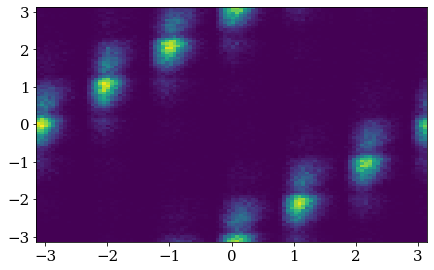

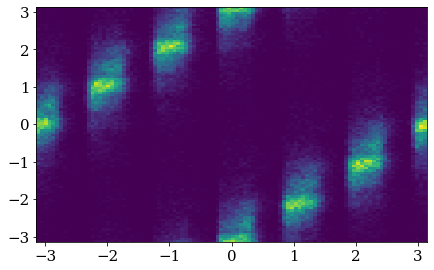

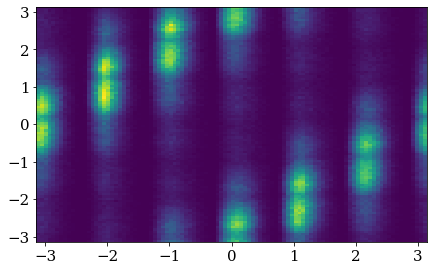

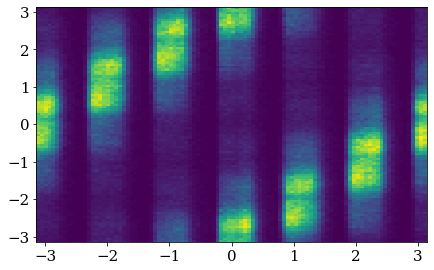

In [39]:
plt.hist2d(inb.e_ph,inb.h1_ph,bins=100)
plt.show()
plt.hist2d(outb.e_ph,outb.h1_ph,bins=100)
plt.show()

plt.hist2d(inb.e_ph,inb.h2_ph,bins=100)
plt.show()
plt.hist2d(outb.e_ph,outb.h2_ph,bins=100)
plt.show()

In [ ]:
dfs = []
for f in glob.glob('/home/sebouh/tuples_hadd/inbend_mixed_50*.root'):
    print(f)
    dfs.append(root_pandas.read_root(f))
print("loaded files")
df = 
print("concatenated files")

In [ ]:
outb_mixed = pd.concat([root_pandas.read_root(f) for f in glob.glob('/home/sebouh/tuples_hadd/outbend_mixed_56xx.root')])

# 

(array([109777., 112501., 115685., 118759., 121669., 124959., 127937.,
        131246., 134987., 138214., 141859., 145893., 148702., 152620.,
        156788., 160680., 164476., 168757., 172953., 176319., 180992.,
        185263., 190048., 193441., 198348., 202335., 207876., 212401.,
        216510., 220708., 225634., 229446., 233773., 238694., 242263.,
        247234., 250400., 254202., 257682., 259996., 264499., 265734.,
        270060., 273456., 275874., 277514., 280098., 282175., 282139.,
        282914., 285802., 285643., 285666., 285544., 284578., 284944.,
        284352., 283982., 282336., 281034., 280043., 276431., 275313.,
        272486., 269564., 267784., 265242., 261855., 258377., 257456.,
        252464., 250430., 246491., 243898., 240108., 236036., 233331.,
        230562., 227120., 223791., 220700., 218772., 215794., 213341.,
        210012., 207309., 205893., 201375., 199035., 196978., 195584.,
        193776., 190676., 189031., 187403., 184778., 183293., 182712.,
      

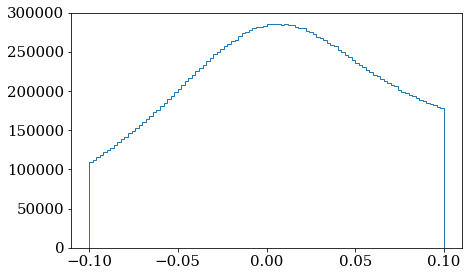

In [5]:
plt.hist(inb_mixed.eval("x-mixevt_x"),bins=100,histtype='step')
#plt.hist(outb_mixed.eval("x-mixevt_x"),bins=100,histtype='step')       

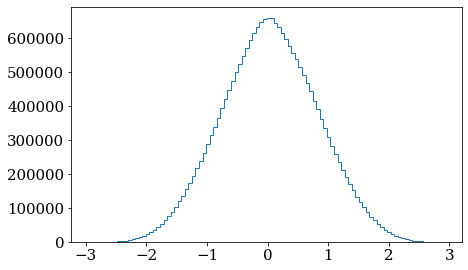

In [7]:
plt.hist(inb_mixed.eval("Q2-mixevt_Q2"),bins=100,histtype='step')
plt.show()

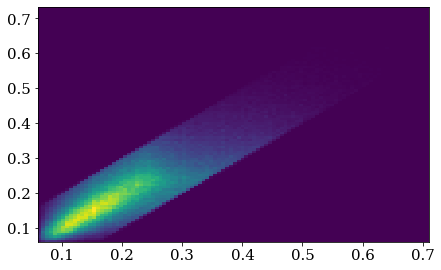

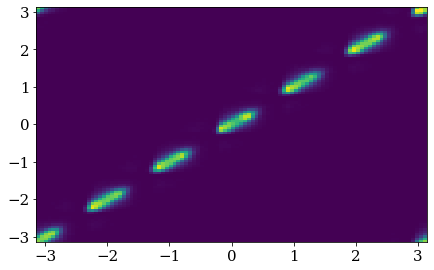

In [32]:
plt.hist2d(mixed_small.x,mixed_small.mixevt_x,bins=100)
plt.show()
plt.hist2d(mixed_small.e_ph,mixed_small.mixevt_e_ph,bins=100)
plt.show()